In [6]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time
import torch.nn as nn
from torchvision import transforms, models
from torchvision.models import ResNet50_Weights


class Food101Dataset(Dataset):
    def __init__(self, data_folder, transform=None):
        self.data_folder = data_folder
        self.transform = transform
        self.classes = sorted(os.listdir(data_folder))
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}
        self.images = self._load_images()

    def _load_images(self):
        images = []
        for cls_name in self.classes:
            cls_path = os.path.join(self.data_folder, cls_name)
            for img_name in os.listdir(cls_path):
                img_path = os.path.join(cls_path, img_name)
                images.append((img_path, self.class_to_idx[cls_name]))
        return images

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path, label = self.images[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

# Define transformation for the images
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Path to your data folder
data_folder = "../data/food-101/images"

# Create dataset
food101_dataset = Food101Dataset(data_folder, transform=transform)

# Create dataloader
batch_size = 1
data_loader = DataLoader(food101_dataset, batch_size=batch_size, shuffle=True)

# for i in food101_dataset:
#     if i[1] == 0:
#         print(i)
#         break


# # Iterate through the dataloader for testing
# for images, labels in data_loader:
#     # Here you can feed the images to your model for testing
#     # Replace this with your model inference code
#     print(images[0].shape)
#     print(labels)
#     break  # Stop iteration after the first batch for testing purposes


# see_examples = 5
# for i, (imgs, label) in enumerate(data_loader):
#     clear_output(wait=True)
#     image = imgs[0].numpy().transpose(1, 2, 0)
#     plt.imshow(image)
#     plt.text(5, 15, label[0], fontsize ='xx-large', color='red', fontweight='bold')
#     plt.show()

#     if i >= see_examples - 1:
#       break
#     time.sleep(1)

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
print(torch.cuda.get_device_name(0))

def test_acc(net: nn.Module, test_loader: DataLoader):

  net.to(device)
  net.eval()
  
  total = 0
  correct = 0

  for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)
    total += labels.size(0)

    outputs = net(images)
    _, predicted = torch.max(outputs, 1)
    correct += (predicted == labels).sum().item()

  return correct / total * 100

cuda
NVIDIA GeForce RTX 4060 Laptop GPU


In [8]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        
        resnet = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
        resnet = nn.Sequential(*list(resnet.children())[:-1])
        for param in resnet.parameters():
            param.requires_grad = False


        self.model = nn.Sequential(
            resnet,
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.25),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.1),
            nn.Linear(128, 101)
        )

    def forward(self, x):
        return self.model(x)

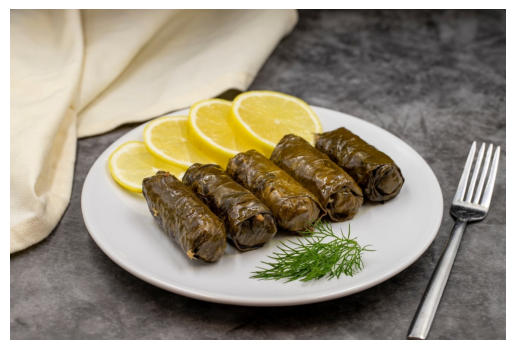

Top 5 predicted classes:
spring_rolls: 82.74%
peking_duck: 3.47%
baklava: 2.31%
breakfast_burrito: 1.07%
cheese_plate: 0.91%


In [16]:
import torch
from torchvision import transforms
from PIL import Image
import torch.nn.functional as F

# Preprocess the input image
def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((512, 512)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    image = Image.open(image_path).convert('RGB')
    image = transform(image)
    # Add batch dimension
    image = image.unsqueeze(0)
    return image

# Function to classify an image
def classify_image(image_path, model, class_labels):
    # Preprocess the image
    image = preprocess_image(image_path)
    
    # Use GPU if available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    image = image.to(device)
    
    # Set the model to evaluation mode
    model.eval()
    
    # Pass the image through the model
    with torch.no_grad():
        output = model(image)
    
    # Calculate probabilities using softmax
    probabilities = F.softmax(output, dim=1)
    
    # Get the top 5 predicted classes
    top5_prob, top5_indices = torch.topk(probabilities, 5)
    
    # Print the probabilities for each class
    # for i in range(len(class_labels)):
    #     print(f'{class_labels[i]}: {probabilities[0][i].item()*100:.2f}%')
    
    return top5_prob, top5_indices

# Path to your image
image_path = "test_images/s4.jpg"
# image_path = "test_images/sp_bol.jpg"

model = Model()

# Load the model
state_dict = torch.load('../cross_validation/000_new_model/model_epoch7.pkl')
model.load_state_dict(state_dict)

# Define class labels
class_labels = food101_dataset.classes

# Classify the image
top5_probabilities, top5_indices = classify_image(image_path, model, class_labels)

image = Image.open(image_path)
plt.imshow(image)
plt.axis('off')
plt.show()

# Print the top 5 predicted classes
print("Top 5 predicted classes:")
for i in range(5):
    print(f"{class_labels[top5_indices[0][i]]}: {top5_probabilities[0][i].item()*100:.2f}%")
